In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor, print_model_size

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [2]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Define a VGG block: multiple conv layers followed by max pooling
        def vgg_block(num_convs, in_channels, out_channels):
            layers = []
            for _ in range(num_convs):
                layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                in_channels = out_channels
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            return nn.Sequential(*layers)
        
        self.features = nn.Sequential(
            # VGG blocks. For CIFAR-10, we use fewer layers.
            vgg_block(1, 3, 64),     # Block 1: 32x32 -> 16x16
            vgg_block(1, 64, 128),   # Block 2: 16x16 -> 8x8
            vgg_block(2, 128, 256),  # Block 3: 8x8 -> 4x4
            vgg_block(2, 256, 512)   # Block 4: 4x4 -> 2x2
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the features
            nn.Linear(512 * 2 * 2, 512),  # Adjusted for final feature map size 2x2
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [3]:
print_model_size(VGG())

Total params = 5.555082e+06
Trainable params = 5.555082e+06


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

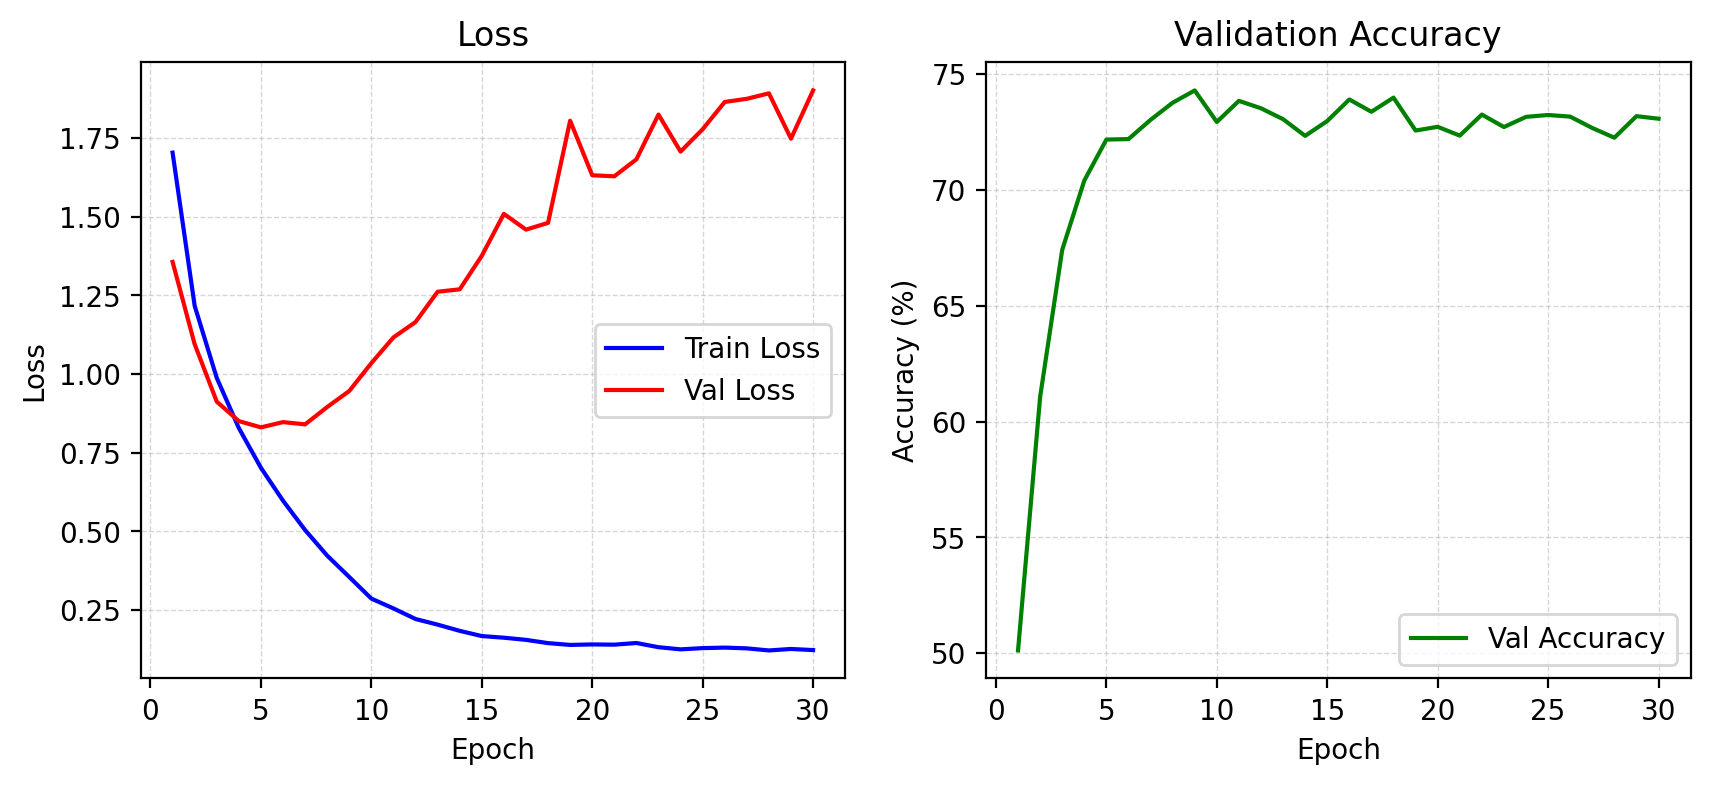

Epoch 30/30: 100%|##########| 30/30 [15:12<00:00, 27.36s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.7032       |       1.3562       |         50.1200         |
|         2          |       1.2167       |       1.0947       |         61.0600         |
|         3          |       0.9877       |       0.9125       |         67.4100         |
|         4          |       0.8286       |       0.8505       |         70.4000         |
|         5          |       0.7022       |       0.8306       |         72.1700         |
|         6          |       0.5978       |       0.8474       |         72.1900         |
|         7          |       0.5045       |       0.8402       |         73.0200         |
|         8          |       0.4234       |       0.8953       |         73.7600         |
|         9          |       0.3554       |       0.9462       |         74.2900         |

In [4]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=64)

model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)
